# Load checkpoint and imports

In [1]:
import os
import sys
parent_dir = "/Midgard/home/farzantn/phd/Olfaction/MoLFormer_N2024"
sys.path.append(parent_dir)
parent_dir="/Midgard/home/farzantn/mambaforge/envs/MolTran_CUDA11_cuda/lib/python3.8"
sys.path.append(parent_dir)

In [2]:
import warnings
device_name='cuda'

from datetime import datetime
from argparse import Namespace
import yaml
import os
import pandas as pd
from rdkit import Chem
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
print(os.getcwd())
import torch
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from custom_utils.tokenizer.tokenizer import MolTranBertTokenizer
from sklearn.model_selection import train_test_split
import rdkit
from sklearn.multioutput import MultiOutputClassifier
from custom_utils.data_utils import get_class_imbalance_ratio
# from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants
# from openpom.utils.loss import CustomMultiLabelLoss
warnings.filterwarnings('ignore')

# from openpom.feat.graph_featurizer import GraphFeaturizer, GraphConvConstants

import deepchem as dc
import rdkit
from utils.gs_lf import *
with open('../custom_utils/hparams.yaml', 'r') as f:
    config = Namespace(**yaml.safe_load(f))

print(torch.cuda.is_available())
from fast_transformers.masking import LengthMask as LM
# from train_pubchem_light import LightningModule
# from openpom.utils.optimizer import get_optimizer
from torch import nn
import torch.nn.functional as F
torch.cuda.is_available()
torch.cuda.current_device()
from utils.gs_lf import *
import seaborn as sns
import pyrfume
from utils.util_alignment import *
from utils.prepare_datasets import *
from utils.custom_models import *
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr  
from sklearn.metrics import r2_score
import itertools
import math
from utils.util_alignment import *
from utils.custom_models import *
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde
import numpy as np
import os
from IPython.display import Image
# from openpom.models.mpnn_pom import MPNNPOMModel
# plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 35
plt.rcParams["figure.figsize"] = (10,10)
# plt.rc('font',**{'family':'serif','serif':['Times']})
from ast import literal_eval
from utils.ridge_tools import *
import ast
from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import multilabel_confusion_matrix,average_precision_score,precision_score,f1_score,recall_score,ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from scipy import stats
from utils.prepare_datasets import *

/Midgard/home/farzantn/phd/Olfaction/MoLFormer_N2024/Notebooks


Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/Midgard/home/farzantn/mambaforge/envs/Mol/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading some Jax models, missing a dependency. No module named 'jax'


/Midgard/home/farzantn/phd/Olfaction/MoLFormer_N2024/Notebooks
True


In [3]:
# base_path  = '../../../../../../T5 EVO/alignment_olfaction_datasets/data/'
base_path = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/'


In [4]:
seed = 2024
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

# helper methods

In [5]:
def metrics(y_true,y_predicted_prob):
    y_pred = np.round(y_predicted_prob)
    average_type = [None, 'macro' , 'weighted']

    # for average in average_type:
    ap = average_precision_score(y_true, y_predicted_prob,average=None)
    ap_macro = average_precision_score(y_true, y_predicted_prob,average='macro')
    ap_weighted = average_precision_score(y_true, y_predicted_prob,average='weighted')
    
    precision = precision_score(y_true, y_pred,average=None)
    precision_macro = precision_score(y_true, y_pred,average='macro')
    precision_weighted = precision_score(y_true, y_pred,average='weighted')


    recall = recall_score(y_true, y_pred,average=None)
    recall_macro = recall_score(y_true, y_pred,average='macro')
    recall_weighted = recall_score(y_true, y_pred,average='weighted')


    f1 = f1_score(y_true, y_pred,average=None)
    f1_macro = f1_score(y_true, y_pred,average='macro')
    f1_weighted = f1_score(y_true, y_pred,average='weighted')

    
    # true_labels = np.round(y_true)
    
    # print(true_labels)
    # print(y_true)
    return ap_macro,precision_macro,recall_macro,f1_macro
    

In [6]:
# def custom_linear_regression(X,y):

    
#     linreg = MultiTaskLassoCV(max_iter=1000,n_alphas=200,random_state=seed,n_jobs=-1)
#     estimator= linreg.fit(X,y)
#     return estimator

In [7]:
# def custom_logistic_regression(X,y):

    
#     logreg = LogisticRegression(max_iter=1000,random_state=seed,n_jobs=-1)
#     estimator= logreg.fit(X,y)
#     return estimator

In [8]:
def pipeline_regression(data_groupbyCID,times,n_components=None,seed=seed):
    mserrorrs_corssvalidated = []
    correlations_corssvalidated = []
    for i in range(times):
        X=np.asarray(data_groupbyCID.embeddings.values.tolist())
        y=np.asarray(data_groupbyCID.y.values.tolist())
        # print("min", X.min())
        # print("max", X.max())
          
        # print("X",X)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed+i)  
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        if n_components is not None:
            pca = PCA(n_components=n_components)
            X_train=pca.fit_transform(X_train)
            X_test=pca.transform(X_test)
        linreg =custom_logistic_regression(X_train,y_train)
        mseerrors, correlations=metrics_per_descritor(X_test,y_test,[str(i) for i in range(y.shape[1])],linreg)
        mserrorrs_corssvalidated.append(mseerrors)
        correlations_corssvalidated.append(correlations)
    return mserrorrs_corssvalidated, correlations_corssvalidated

In [9]:
def mAP(targs, preds, pos_thr=0.5):
    """Returns the model's average precision for each class
    Return:
        ap (FloatTensor): 1xK tensor, with avg precision for each class k
    """
    def average_precision(output, target):
        epsilon = 1e-8

        # sort examples
        indices = output.argsort()[::-1]
        # Computes prec@i
        total_count_ = np.cumsum(np.ones((len(output), 1)))

        target_ = target[indices]
        ind = target_ == 1
        pos_count_ = np.cumsum(ind)
        total = pos_count_[-1]
        pos_count_[np.logical_not(ind)] = 0
        pp = pos_count_ / total_count_
        precision_at_i_ = np.sum(pp)
        precision_at_i = precision_at_i_ / (total + epsilon)

        return precision_at_i

    if np.size(preds) == 0:
        return 0
    ap = np.zeros((preds.shape[1]))
    # compute average precision for each class
    for k in range(preds.shape[1]):
        scores = preds[:, k]
        targets = targs[:, k]
        ap[k] = average_precision(scores, targets)
    tp, fp, fn, tn = [], [], [], []
    conf_matrices = []

    for k in range(preds.shape[0]):
        scores = preds[k,:]
        targets = targs[k,:]
        pred = (scores > pos_thr).astype(np.int32)
        tp.append(((pred + targets) == 2).sum())
        fp.append(((pred - targets) == 1).sum())
        fn.append(((pred - targets) == -1).sum())
        tn.append(((pred + targets) == 0).sum())
        conf_matrices.append(confusion_matrix(targets, pred))

    p_c = [tp[i] / (tp[i] + fp[i]) if tp[i] > 0 else 0.0 for i in range(len(tp))]
    r_c = [tp[i] / (tp[i] + fn[i]) if tp[i] > 0 else 0.0
                for i in range(len(tp))]
    f_c = [2 * p_c[i] * r_c[i] / (p_c[i] + r_c[i]) if tp[i] > 0 else 0.0
                for i in range(len(tp))]

    mean_p_c = sum(p_c) / len(p_c)
    mean_r_c = sum(r_c) / len(r_c)
    mean_f_c = sum(f_c) / len(f_c)

    p_o = sum(tp) / (np.array(tp) + np.array(fp)).sum()
    r_o = sum(tp) / (np.array(tp) + np.array(fn)).sum()
    f_o = 2 * p_o * r_o / (p_o + r_o)
    roc_auc=roc_auc_score(targs, preds)
    # cm =multilabel_confusion_matrix(targets, pred)

    # for i in range(targets.shape[1]):
        

    return ap.mean(), mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc,conf_matrices


def tune_multilabel_thresholds(raw_scores, labels):
    scores = 1. / (1. + np.exp(-1. * raw_scores))
    threshs = np.zeros(labels.shape[1])

    for j in range(labels.shape[1]):
        precision, recall, thresholds = precision_recall_curve(labels[:, j], scores[:, j])
        fscore = (2 * precision * recall) / (precision + recall)
        threshs[j] = thresholds[np.argmax(fscore)]

    return threshs

In [10]:
def run_linear_classifier(modeldeepchem,embedding_dataset,embedding_test_dataset,metric,metric_str,nb_epoch = 2):
    start_time = datetime.now()
    
    train_scores=[]
    valid_scores=[]
    losses=[]
    for epoch in range(1, nb_epoch+1):
        loss = modeldeepchem.fit(
              embedding_dataset,
              nb_epoch=1,
              max_checkpoints_to_keep=1,
              deterministic=False,
              restore=epoch>1)
        losses.append(loss)
        # print(epoch,loss)
    
    modeldeepchem.save_checkpoint()
    end_time = datetime.now()
    return modeldeepchem,train_scores,valid_scores,losses


In [11]:
def create_linear_classifier(TASKS, n_classes,train_ratios,mode="classification",n_dim=768):
    n_classes = 1
    n_tasks= len(TASKS)
    if mode == "classification":
        model = NonLinearModel(n_tasks).to(device_name)
    elif mode == "classification_linear":
        model = LinearModel(n_tasks,n_dim).to(device_name)
    elif mode == "classification_small":
        model = LinearModelSmall(n_tasks).to(device_name)
    elif mode== "regression":
        model = LinearModelRegression(n_tasks).to(device_name)
    elif mode== "classification_alva":
        model = LinearModelAlva(n_tasks).to(device_name)
    # model.n_tasks=n_tasks
    model.n_classes=1
    
    # ratios = get_class_imbalance_ratio(train_dataset)
    lr = 1e-4
    
    learning_rate = 0.001
    modeldeepchem = LinearModelMultiLabelDeepchem(\
        model=model,class_imbalance_ratio=train_ratios,loss_aggr_type='sum',\
        device_name=device_name,mode=mode,optimizer_name = 'adam',\
        learning_rate=learning_rate,batch_size=128)
    
    return modeldeepchem
    

In [12]:

def prepare_dataset(ds):
    ds['y'] = ds['y'].apply(ast.literal_eval)
    ds['embeddings'] = ds['embeddings'].apply(ast.literal_eval)
    return ds

In [13]:
def prepare_dataset_proba(ds):
    ds['y'] = ds['y'].apply(ast.literal_eval)
    ds['proba'] = ds['proba'].apply(ast.literal_eval)
    return ds

In [14]:
def select_features(input_file):
    ds_alva = pd.read_csv(input_file)


    chemical_features_r=["nCIR",
                     "ZM1", 
                     "GNar", 
                     "S1K", 
                     "piPC08",
                     "MATS1v",
                     "MATS7v",
                     "GATS1v", 
                     "Eig05_AEA(bo)", 
                     "SM02_AEA(bo)",
                     "SM03_AEA(dm)",
                     "SM10_AEA(dm)",
                     "SM13_AEA(dm)",
                      "SpMin3_Bh(v)",
                     "RDF035v",
                     "G1m",
                     "G1v",
                     "G1e",
                     "G3s",
                     "R8u+",
                     "nRCOSR"]

    nonStereoSMILE = list(map(lambda x: "nonStereoSMILES___" + x, chemical_features_r))
    # IsomericSMILES = list(map(lambda x: "IsomericSMILES___" + x, chemical_features_r))
    selected_features = nonStereoSMILE
    features= ['main_idx','nonStereoSMILES']+selected_features
    # print("cc1", ds_alva.columns.values.tolist())
    ds_alva= ds_alva.rename(columns={"Unnamed: 0":"main_idx"})
    # print("cc2", ds_alva.columns.values.tolist())
    ds_alva_selected = ds_alva[features]
    ds_alva_selected = ds_alva_selected.fillna(0)
    ds_alva_selected['embeddings'] = ds_alva_selected[selected_features].values.tolist()
    return ds_alva_selected

In [15]:
def pipeline(input_file_alva,gs_lf_molformer,times=30,n_components=None,ds="keller",seed=seed):
    # input_file_keller = base_path+'openpom/data/curated_datasets/embeddings/molformer/keller_molformer_embeddings_13_Apr17.csv'
    

    
    keller_alva = select_features(input_file_keller_alva)
    keller_groupbyCID= pd.merge(keller_alva,keller_behavior,on="CID")
    
        
    mserrorrs_keller_corssvalidated, correlations_keller_corssvalidated=pipeline_regression(keller_groupbyCID,times=times,n_components=n_components,seed=seed)
    mserrorrs_mean_keller,mserrorrs_std_keller,correlations_mean_keller,correlations_std_keller =post_process_results(mserrorrs_keller_corssvalidated, correlations_keller_corssvalidated)
    mserrorrs_corssvalidated_keller,statistics_correlations_corssvalidated_keller,pvalues_correlations_corssvalidated_keller=post_process_results_df(mserrorrs_keller_corssvalidated, correlations_keller_corssvalidated)
    df_keller_mse= pd.DataFrame(mserrorrs_corssvalidated_keller)
    df_keller_mse['model'] = model_name
    df_keller_cor= pd.DataFrame(statistics_correlations_corssvalidated_keller)
    df_keller_cor['model'] = model_name
    # df_keller = pd.concat((df_keller_molformer,df_keller_pom))
    return df_keller_mse, df_keller_cor

In [16]:
from sklearn.multiclass import OneVsRestClassifier
def custom_logistic_regression(X,y):
    # print(y.shape)
    clf = LogisticRegressionCV(cv=5, random_state=seed,max_iter=200,scoring='roc_auc')
    multi_clf =  OneVsRestClassifier(clf,n_jobs=-1)
    # if len(y.shape)>1:
    #     linreg = MultiTaskLassoCV(max_iter=1000,n_alphas=200,random_state=seed,n_jobs=-1)
    # else:
    #     linreg = LassoCV(max_iter=1000,n_alphas=200,random_state=seed,n_jobs=-1)
    
    estimator= multi_clf.fit(X,y)
    return estimator

In [17]:
def pipeline_regression(X_train,y_train,X_test,y_test,n_components=None):
    mserrorrs_corssvalidated = []
    correlations_corssvalidated = []

    # print("min", X.min())
    # print("max", X.max())
      
    
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed+i)  
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    if n_components is not None:
        pca = PCA(n_components=n_components)
        X_train=pca.fit_transform(X_train)
        X_test=pca.transform(X_test)
    linreg =custom_logistic_regression(X_train,y_train)
    return linreg,X_test
    # predicted_probs = linreg.predict_proba(X_test)
    # predicted_labels = linreg.predict(X_test)
    # mseerrors, correlations=metrics_per_descritor(X_test,y_test,linreg)
    # mserrorrs_corssvalidated.append(mseerrors)
    # correlations_corssvalidated.append(correlations)
    # return predicted_probs,predicted_labels

## Loading MolFormer Model

# Loading Human Embeddings

## Extracting embedding from MoLFormer for GS-LF

In [18]:
def read_by_idx(input_file_indices,input_file_data):

    # input_file_indices = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf-splits-idx.csv' # or new downloaded file path
    indices = pd.read_csv(input_file_indices)
    indices_train = indices.loc[indices['split']=='train']['main_idx'].values.tolist()
    indices_valid = indices.loc[indices['split']=='valid']['main_idx'].values.tolist()
    indices_test = indices.loc[indices['split']=='test']['main_idx'].values.tolist()
    
    
    # input_file_molformer = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/molformer/gslf_molformer_embeddings_13_Apr17.csv'
    gs_lf=pd.read_csv(input_file_data)
    gs_lf=prepare_dataset(gs_lf)
    
    
    gs_lf_np = np.asarray(gs_lf.embeddings.tolist())
    gs_lf_y = np.asarray(gs_lf.y.tolist())
    gs_lf_embeddings_train = gs_lf_np[indices_train]
    gs_lf_y_train = gs_lf_y[indices_train]
    
    gs_lf_embeddings_test = gs_lf_np[indices_test]
    gs_lf_y_test = gs_lf_y[indices_test]
    
    gs_lf_embeddings_valid = gs_lf_np[indices_valid]
    gs_lf_y_valid = gs_lf_y[indices_valid]
    
    embedding_train_dataset_gslf = dc.data.DiskDataset.from_numpy(gs_lf_embeddings_train,gs_lf_y_train)
    embedding_test_dataset_gslf = dc.data.DiskDataset.from_numpy(gs_lf_embeddings_test,gs_lf_y_test)
    embedding_valid_dataset_gslf = dc.data.DiskDataset.from_numpy(gs_lf_embeddings_valid,gs_lf_y_valid)

    return gs_lf_embeddings_train,gs_lf_y_train,\
    gs_lf_embeddings_test,gs_lf_y_test,\
    gs_lf_embeddings_valid,gs_lf_y_valid,\
    embedding_train_dataset_gslf,embedding_test_dataset_gslf,embedding_valid_dataset_gslf

In [19]:
def read_by_idx_predicted(input_file_indices,input_file_data):

    # input_file_indices = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf-splits-idx.csv' # or new downloaded file path
    indices = pd.read_csv(input_file_indices)
    indices_train = indices.loc[indices['split']=='train']['main_idx'].values.tolist()
    indices_valid = indices.loc[indices['split']=='valid']['main_idx'].values.tolist()
    indices_test = indices.loc[indices['split']=='test']['main_idx'].values.tolist()
    
    
    # input_file_molformer = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/molformer/gslf_molformer_embeddings_13_Apr17.csv'
    gs_lf=pd.read_csv(input_file_data)
    gs_lf=prepare_dataset(gs_lf)
    
    
    gs_lf_np = np.asarray(gs_lf.embeddings.tolist())
    gs_lf_y = np.asarray(gs_lf.y.tolist())
    gs_lf_embeddings_train = gs_lf_np[indices_train]
    gs_lf_y_train = gs_lf_y[indices_train]
    
    gs_lf_embeddings_test = gs_lf_np[indices_test]
    gs_lf_y_test = gs_lf_y[indices_test]
    
    gs_lf_embeddings_valid = gs_lf_np[indices_valid]
    gs_lf_y_valid = gs_lf_y[indices_valid]
    
    embedding_train_dataset_gslf = dc.data.DiskDataset.from_numpy(gs_lf_embeddings_train,gs_lf_y_train)
    embedding_test_dataset_gslf = dc.data.DiskDataset.from_numpy(gs_lf_embeddings_test,gs_lf_y_test)
    embedding_valid_dataset_gslf = dc.data.DiskDataset.from_numpy(gs_lf_embeddings_valid,gs_lf_y_valid)

    return gs_lf_embeddings_train,gs_lf_y_train,\
    gs_lf_embeddings_test,gs_lf_y_test,\
    gs_lf_embeddings_valid,gs_lf_y_valid,\
    embedding_train_dataset_gslf,embedding_test_dataset_gslf,embedding_valid_dataset_gslf

In [20]:
def read_by_idx_alva(input_file_indices,input_file_data,gs_lf_alva):

    indices = pd.read_csv(input_file_indices)
    indices_train = indices.loc[indices['split']=='train']['main_idx'].values.tolist()
    indices_valid = indices.loc[indices['split']=='valid']['main_idx'].values.tolist()
    indices_test = indices.loc[indices['split']=='test']['main_idx'].values.tolist()

    
    # gs_lf_alva
    # gs_lf_alva.columns.values.tolist()
    gs_lf_alva_np = np.asarray(gs_lf_alva.embeddings.tolist())
    gs_lf_alva_y = np.asarray(gs_lf_alva.y.tolist())
    
    
    gs_lf_alva_features_train = gs_lf_alva_np[indices_train]
    gs_lf_alva_y_train = gs_lf_alva_y[indices_train]
    
    gs_lf_alva_features_test = gs_lf_alva_np[indices_test]
    gs_lf_alva_y_test = gs_lf_alva_y[indices_test]
    
    gs_lf_alva_features_valid = gs_lf_alva_np[indices_valid]
    gs_lf_alva_y_valid = gs_lf_alva_y[indices_valid]


    embedding_train_dataset_gslf_alva = dc.data.DiskDataset.from_numpy(gs_lf_alva_features_train,gs_lf_alva_y_train)
    embedding_test_dataset_gslf_alva = dc.data.DiskDataset.from_numpy(gs_lf_alva_features_test,gs_lf_alva_y_test)
    embedding_valid_dataset_gslf_alva = dc.data.DiskDataset.from_numpy(gs_lf_alva_features_valid,gs_lf_alva_y_valid)


    return gs_lf_alva_features_train,gs_lf_alva_y_train,\
    gs_lf_alva_features_test,gs_lf_alva_y_test,\
    gs_lf_alva_features_valid,gs_lf_alva_y_valid,\
    embedding_train_dataset_gslf_alva,embedding_test_dataset_gslf_alva,embedding_valid_dataset_gslf_alva
    
    # gs_lf_y.columns.

In [21]:
def train_and_eval(gs_lf_embeddings_train,gs_lf_embeddings_valid,gs_lf_embeddings_test,gs_lf_y_train,gs_lf_y_valid,gs_lf_y_test):
    gs_lf_embeddings_train_valid = np.vstack((gs_lf_embeddings_train,gs_lf_embeddings_valid))
    gs_lf_y_train_valid = np.vstack((gs_lf_y_train,gs_lf_y_valid))
    linreg,X_test = pipeline_regression(gs_lf_embeddings_train_valid,gs_lf_y_train_valid,gs_lf_embeddings_test,gs_lf_y_test,n_components=20)
    predicted_probs = linreg.predict_proba(X_test)
    predicted_labels = linreg.predict(X_test)
    roc_auc_score_test = roc_auc_score(gs_lf_y_test,
    predicted_probs,
    multi_class="ovr",
    average="micro")
    return roc_auc_score_test

In [22]:
def train_and_eval2(gs_lf_embeddings_train,gs_lf_embeddings_valid,gs_lf_embeddings_test,gs_lf_y_train,gs_lf_y_valid,gs_lf_y_test):
    gs_lf_embeddings_train_valid = np.vstack((gs_lf_embeddings_train,gs_lf_embeddings_valid))
    gs_lf_y_train_valid = np.vstack((gs_lf_y_train,gs_lf_y_valid))
    linreg,X_test = pipeline_regression(gs_lf_embeddings_train_valid,gs_lf_y_train_valid,gs_lf_embeddings_test,gs_lf_y_test,n_components=20)
    predicted_probs = linreg.predict_proba(X_test)
    predicted_labels = linreg.predict(X_test)


    # Compute ROC curve and ROC area for each class
    all_fpr = []
    all_tpr = []
    all_roc_auc = []
    for j in range(gs_lf_y_train_valid.shape[1]):
        fpr, tpr, _ = roc_curve(gs_lf_y_test[:, j], predicted_probs[:, j])
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_roc_auc.append(auc(fpr, tpr))
    
    # Compute micro-average ROC curve and ROC area
    all_fpr = np.concatenate(all_fpr)
    all_tpr = np.concatenate(all_tpr)
    mean_fpr = np.linspace(0, 1, 5000)
    mean_tpr = np.interp(mean_fpr, all_fpr, all_tpr)
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0
    roc_auc_score_test = roc_auc_score(gs_lf_y_test,
    predicted_probs,
    multi_class="ovr",
    average="micro")
    # tprs.append(mean_tpr)
    # aucs.append(roc_auc)
    
    
    return mean_fpr, mean_tpr,roc_auc_score_test

In [23]:
def only_eval(gs_lf_y_test, predicted_probs):
    roc_auc_score_test = roc_auc_score(gs_lf_y_test,
    predicted_probs,
    multi_class="ovr",
    average="micro")
    return roc_auc_score_test

In [24]:
def only_eval2(gs_lf_y_test, predicted_probs):
    # Compute ROC curve and ROC area for each class
    all_fpr = []
    all_tpr = []
    all_roc_auc = []
    for j in range(gs_lf_y_test.shape[1]):
        fpr, tpr, _ = roc_curve(gs_lf_y_test[:, j], predicted_probs[:, j])
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_roc_auc.append(auc(fpr, tpr))
    
    # Compute micro-average ROC curve and ROC area
    all_fpr = np.concatenate(all_fpr)
    all_tpr = np.concatenate(all_tpr)
    mean_fpr = np.linspace(0, 1, 5000)
    mean_tpr = np.interp(mean_fpr, all_fpr, all_tpr)
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0
    roc_auc_score_test = roc_auc_score(gs_lf_y_test,
    predicted_probs,
    multi_class="ovr",
    average="micro")
    # tprs.append(mean_tpr)
    # aucs.append(roc_auc)
    return mean_fpr, mean_tpr,roc_auc_score_test

In [25]:
def compute_paramters(layer):
    roc_poms=[]
    roc_molformers=[]
    roc_alvas=[]
    
    for i in range(1,31):
    
        input_file_indices = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf-splits-idx-'+str(i)+'.csv'
        input_file_data = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf_pom_proba_'+str(i)+'_Apr17.csv'
        
        gs_lf_pom_embeddings_train,gs_lf_pom_y_train,\
            gs_lf_pom_embeddings_test,gs_lf_pom_y_test,\
            gs_lf_pom_embeddings_valid,gs_lf_pom_y_valid,\
            embedding_train_dataset_gslf,embedding_test_dataset_gslf,embedding_valid_dataset_gslf=read_by_idx(input_file_indices,input_file_data)
      
        gs_lf_pom=pd.read_csv(input_file_data)
        
        input_file_data = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/molformer/gslf_molformer_embeddings_'+str(layer)+'_Apr17.csv'
 
        gs_lf_molformer_embeddings_train,gs_lf_molformer_y_train,\
           gs_lf_molformer_embeddings_test,gs_lf_molformer_y_test,\
           gs_lf_molformer_embeddings_valid,gs_lf_molformer_y_valid,\
           embedding_train_dataset_gslf,embedding_test_dataset_gslf,embedding_valid_dataset_gslf=read_by_idx(input_file_indices,input_file_data)
        
    
    
        input_file_alva= '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/alva/gslf_molecules_alva_17Apr.csv'
        
        gs_lf_alva=select_features(input_file_alva)
        gs_lf_y=gs_lf_pom.copy() #only keep y
        gs_lf_y.index.names = ['main_idx'] 
        del gs_lf_y['embeddings']
        gs_lf_alva=pd.merge(gs_lf_alva, gs_lf_y, on='main_idx')
        gs_lf_alva['y'] = gs_lf_alva['y'].apply(ast.literal_eval)
        gs_lf_alva_embeddings_train,gs_lf_alva_y_train,\
        gs_lf_alva_embeddings_test,gs_lf_alva_y_test,\
        gs_lf_alva_embeddings_valid,gs_lf_alva_y_valid,\
        embedding_train_dataset_gslf_alva,embedding_test_dataset_gslf_alva,embedding_valid_dataset_gslf_alva=read_by_idx_alva(input_file_indices,input_file_alva,gs_lf_alva)
    
        
        roc_pom = only_eval(gs_lf_pom_y_test, gs_lf_pom_embeddings_test)
        # print(gs_lf_molformer_y_train.shape)
        # print(gs_lf_molformer_y_valid.shape)
        roc_molformer =train_and_eval(gs_lf_molformer_embeddings_train,gs_lf_molformer_embeddings_valid,gs_lf_molformer_embeddings_test,gs_lf_molformer_y_train,gs_lf_molformer_y_valid,gs_lf_molformer_y_test)
        # print(gs_lf_alva_y_train)
        # print(gs_lf_alva_y_valid.shape)
        roc_alva = train_and_eval(gs_lf_alva_embeddings_train,gs_lf_alva_embeddings_valid,gs_lf_alva_embeddings_test,gs_lf_alva_y_train,gs_lf_alva_y_valid,gs_lf_alva_y_test)


        roc_poms.append(roc_pom)
        roc_molformers.append(roc_molformer)
        roc_alvas.append(roc_alva)
        print(roc_pom,roc_molformer,roc_alva)
    return roc_poms, roc_molformers, roc_alvas

    

In [26]:
def plot_mean(tprs,mean_fpr,aucs):
    # Calculate the mean and standard deviation of the TPRs
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plot the mean ROC curve
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
             lw=2, alpha=.8)
    
    # Calculate the standard deviation of the TPRs
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    # Fill the area between the TPRs
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)
    
    # Plot chance level
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Micro-averaged ROC Curve with Mean and SE')
    plt.legend(loc="lower right")
    plt.show()

In [27]:
def compute_paramters_plot_alva(layer,color):
    aucs=[]
    tprs=[]
    mean_fpr = np.linspace(0, 1, 5000)
    fig, ax = plt.subplots(figsize=(10, 10)) 
    
    for i in range(1,31):
    
        input_file_indices = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf-splits-idx-'+str(i)+'.csv'
        input_file_data = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf_pom_proba_'+str(i)+'_Apr17.csv'
        
        gs_lf_pom_embeddings_train,gs_lf_pom_y_train,\
            gs_lf_pom_embeddings_test,gs_lf_pom_y_test,\
            gs_lf_pom_embeddings_valid,gs_lf_pom_y_valid,\
            embedding_train_dataset_gslf,embedding_test_dataset_gslf,embedding_valid_dataset_gslf=read_by_idx(input_file_indices,input_file_data)
      
        gs_lf_pom=pd.read_csv(input_file_data)
        
        input_file_data = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/molformer/gslf_molformer_embeddings_'+str(layer)+'_Apr17.csv'
 
        gs_lf_molformer_embeddings_train,gs_lf_molformer_y_train,\
           gs_lf_molformer_embeddings_test,gs_lf_molformer_y_test,\
           gs_lf_molformer_embeddings_valid,gs_lf_molformer_y_valid,\
           embedding_train_dataset_gslf,embedding_test_dataset_gslf,embedding_valid_dataset_gslf=read_by_idx(input_file_indices,input_file_data)
        
    
    
        input_file_alva= '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/alva/gslf_molecules_alva_17Apr.csv'
        
        gs_lf_alva=select_features(input_file_alva)
        gs_lf_y=gs_lf_pom.copy() #only keep y
        gs_lf_y.index.names = ['main_idx'] 
        del gs_lf_y['embeddings']
        gs_lf_alva=pd.merge(gs_lf_alva, gs_lf_y, on='main_idx')
        gs_lf_alva['y'] = gs_lf_alva['y'].apply(ast.literal_eval)
        gs_lf_alva_embeddings_train,gs_lf_alva_y_train,\
        gs_lf_alva_embeddings_test,gs_lf_alva_y_test,\
        gs_lf_alva_embeddings_valid,gs_lf_alva_y_valid,\
        embedding_train_dataset_gslf_alva,embedding_test_dataset_gslf_alva,embedding_valid_dataset_gslf_alva=read_by_idx_alva(input_file_indices,input_file_alva,gs_lf_alva)
    
        
        # fpr_pom, tpr_pom,roc_auc_pom  = only_eval2(gs_lf_pom_y_test, gs_lf_pom_embeddings_test)
        # print(gs_lf_molformer_y_train.shape)
        # print(gs_lf_molformer_y_valid.shape)
        # fpr_molformer, tpr_molformer,roc_auc_molformer  =train_and_eval2(gs_lf_molformer_embeddings_train,gs_lf_molformer_embeddings_valid,gs_lf_molformer_embeddings_test,gs_lf_molformer_y_train,gs_lf_molformer_y_valid,gs_lf_molformer_y_test)
        # print(gs_lf_alva_y_train)
        # print(gs_lf_alva_y_valid.shape)
        fpr_alva, tpr_alva,roc_alva = train_and_eval2(gs_lf_alva_embeddings_train,gs_lf_alva_embeddings_valid,gs_lf_alva_embeddings_test,gs_lf_alva_y_train,gs_lf_alva_y_valid,gs_lf_alva_y_test)

        # tprs.append(tpr)
        # aucs.append(roc_auc)
    
        # plt.plot(fpr, tpr, lw=1, alpha=0.3, label='')
        
        aucs.append(roc_alva)

        tprs.append(tpr_alva)


        plt.plot(fpr_alva, tpr_alva, lw=1, alpha=0.3, label='')
        # ax[0,2].plot(fpr_pom, tpr_pom, lw=1, alpha=0.3, label='')
        # ax[0,3].plot(fpr_alva, tpr_alva, lw=1, alpha=0.3, label='')


    # Calculate the mean and standard deviation of the TPRs
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    # Plot the mean ROC curve
    plt.plot(mean_fpr, mean_tpr, color=color,
             label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
             lw=7, alpha=.8)
    
    # Calculate the standard deviation of the TPRs
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    # Fill the area between the TPRs
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.2)
    
    # Plot chance level
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Micro-averaged ROC Curve with Mean and SE')
    # plt.legend(loc="lower right")
    
    

    plt.subplots_adjust(hspace = 0.65)
    plt.legend(loc="lower right")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    print(labels)
    fig.subplots_adjust(bottom=0,left=0.1,right=0.95,top=0.7)
    # labels = ['MoLFormer', 'POM']
    ax.legend(handles, labels, ncol=2, columnspacing=1, prop={'size': 30}, handlelength=1.5, loc="lower center",
               borderpad=0.3,
               
               bbox_to_anchor=(0.5, -0.3), 
               
               frameon=True, labelspacing=0.4,handletextpad=0.2,)
    # plt.legend(title='Smoker', loc='upper left',)

    plt.tight_layout()

    fig.savefig("alva_rocauc.pdf", bbox_inches='tight')
    plt.show()

        # print(roc_pom,roc_molformer,roc_alva)
    # return roc_poms, roc_molformers, roc_alvas

    

In [28]:
def compute_paramters_molformer(layer):
    roc_molformers=[]
    
    for i in range(1,31):
    
        input_file_indices = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf-splits-idx-'+str(i)+'.csv'
        
        input_file_data = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/molformer/gslf_molformer_embeddings_'+str(layer)+'_Apr17.csv'
 
        gs_lf_molformer_embeddings_train,gs_lf_molformer_y_train,\
           gs_lf_molformer_embeddings_test,gs_lf_molformer_y_test,\
           gs_lf_molformer_embeddings_valid,gs_lf_molformer_y_valid,\
           embedding_train_dataset_gslf,embedding_test_dataset_gslf,embedding_valid_dataset_gslf=read_by_idx(input_file_indices,input_file_data)
        
    
    
        roc_molformer =train_and_eval(gs_lf_molformer_embeddings_train,gs_lf_molformer_embeddings_valid,gs_lf_molformer_embeddings_test,gs_lf_molformer_y_train,gs_lf_molformer_y_valid,gs_lf_molformer_y_test)
        
        roc_molformers.append(roc_molformer)
        print(roc_molformer)
    return roc_molformers

    

In [29]:

def plot_roc_auc_mean(base_path,index,data,color,x_att,y_att,train=True,ds='alva'):
    mean_fpr = np.linspace(0, 1, 5000)
    tprs = []
    aucs = []
    fig, ax = plt.subplots(figsize=(10, 10)) 
    
    
    for i in range(1,3):    
        input_file_indices = index+str(i)+'.csv'
        indices_train,indices_valid,indices_test = extract_set_idxs(base_path, indices_path=input_file_indices)
    
        if train: 
            input_file_data = data+'_Apr17.csv'
        else:
            input_file_data = data+str(i)+'_Apr17.csv'
            
        gs_lf, gs_lf_np,gs_lf_y,gs_lf_embeddings_train,gs_lf_y_train,gs_lf_embeddings_valid,gs_lf_y_valid,gs_lf_embeddings_test,gs_lf_y_test = extract_set_from_indices(base_path,input_file_data ,x_att,y_att, indices_train, indices_valid, indices_test)

        if train:
            fpr, tpr,roc_auc = train_and_eval2(gs_lf_embeddings_train,gs_lf_embeddings_valid,gs_lf_embeddings_test,gs_lf_y_train,gs_lf_y_valid,gs_lf_y_test)
        else:
            fpr, tpr,roc_auc = only_eval2( gs_lf_y_test, gs_lf_embeddings_test)

        
        tprs.append(tpr)
        aucs.append(roc_auc)
        print(roc_auc)
    
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='')
    
    
    # Calculate the mean and standard deviation of the TPRs
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    
    # Plot the mean ROC curve
    plt.plot(mean_fpr, mean_tpr, color=color,
             label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})',
             lw=7, alpha=.8)
    
    # Calculate the standard deviation of the TPRs
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

    # Fill the area between the TPRs
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.2)
    
    # Plot chance level
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Micro-averaged ROC Curve with Mean and SE')
    plt.legend(loc="lower right")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)



    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    print(labels)
    fig.subplots_adjust(bottom=0,left=0.1,right=0.95,top=0.7)
    # labels = ['MoLFormer', 'POM']
    ax.legend(handles, labels, ncol=2, columnspacing=1, prop={'size': 30}, handlelength=1.5, loc="lower center",
               borderpad=0.3,
               
               bbox_to_anchor=(0.5, -0.3), 
               
               frameon=True, labelspacing=0.4,handletextpad=0.2,)
    # plt.legend(title='Smoker', loc='upper left',)

    plt.tight_layout()

    fig.savefig(ds+".pdf", bbox_inches='tight')
    
    plt.show()

# Training Classifiers using DeepChem 

### Linear and Plot

0.9700264535682306
0.973991461189351
['Mean ROC (AUC = 0.97 ± 0.00)', 'Chance']


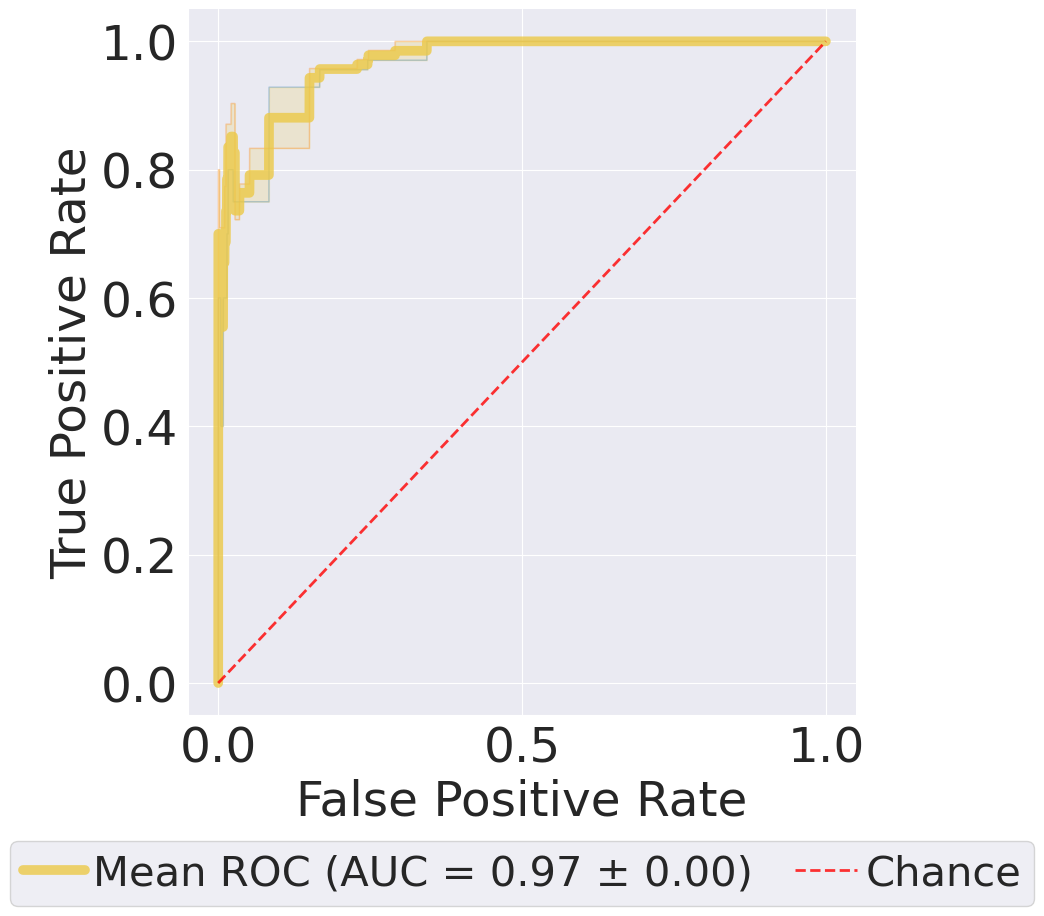

In [32]:
input_file_indices = 'curated_datasets/embeddings/pom/gslf-splits-idx-'
input_file_data = 'curated_datasets/embeddings/pom/gslf_pom_proba_'
# ['#4d79a4','#ecc947','#b07aa0']       
plot_roc_auc_mean(base_path,input_file_indices,input_file_data,x_att='embeddings',y_att='y',color='#ecc947',train=False,ds="pom_rocauc")

0.8881695274802875
0.8830078545360969
['Mean ROC (AUC = 0.89 ± 0.00)', 'Chance']


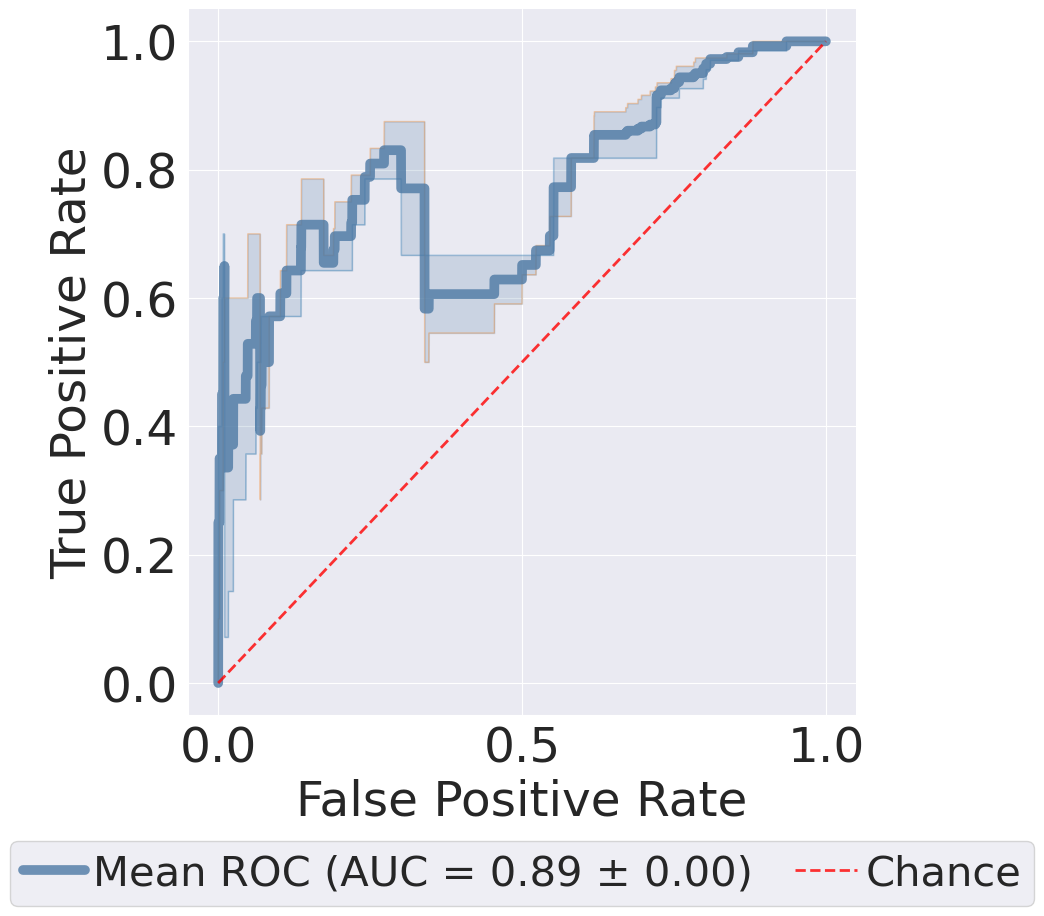

In [35]:
input_file_indices = 'curated_datasets/embeddings/pom/gslf-splits-idx-'
input_file_data = 'curated_datasets/embeddings/molformer/gslf_molformer_embeddings_13'
# ['#4d79a4','#ecc947','#b07aa0']       
plot_roc_auc_mean(base_path,input_file_indices,input_file_data,color='#4d79a4',x_att='embeddings',y_att='y',train=True,ds="molformer_rocauc")

['Mean ROC (AUC = 0.87 ± 0.00)', 'Chance']


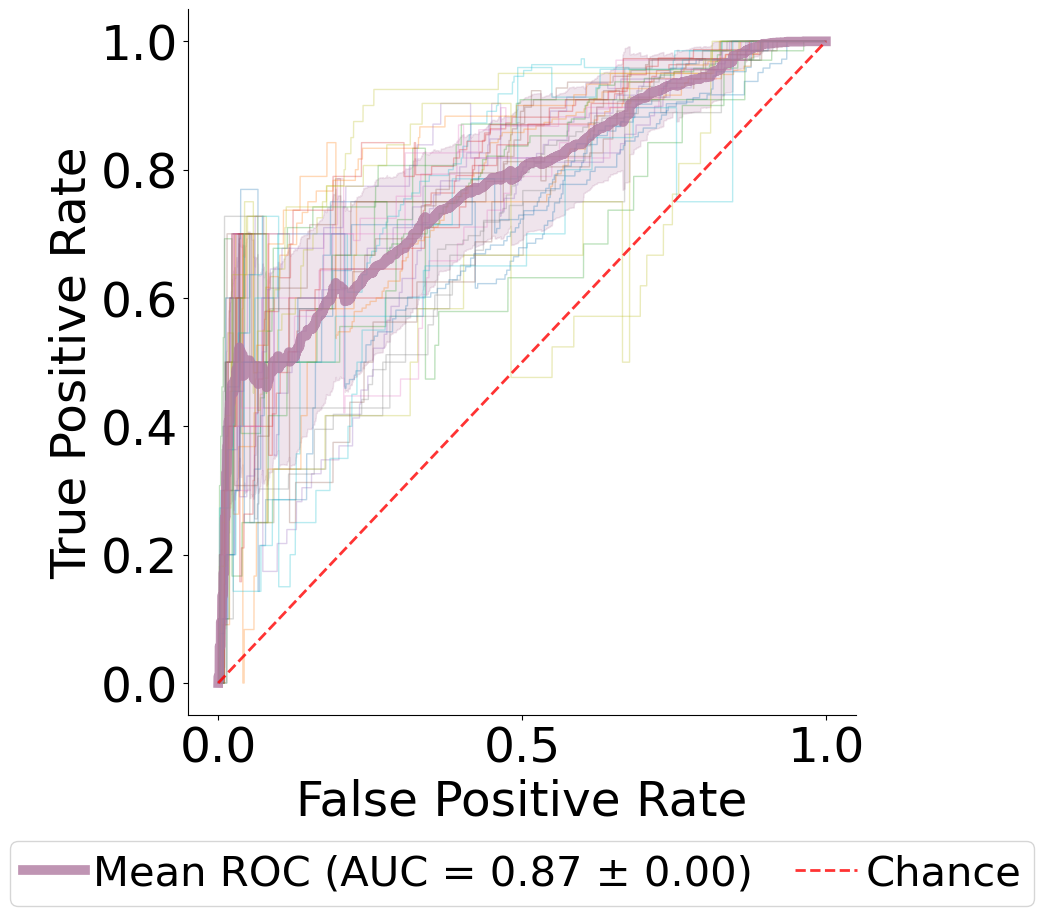

/Midgard/home/farzantn/mambaforge/envs/Mol/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Midgard/home/farzantn/mambaforge/envs/Mol/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

In [35]:
compute_paramters_plot_alva(13,color='#b07aa0')

##  Training a Linear Classifier using DeepChem and Embeddding of GS-LF extracted from MoLFormer

In [34]:
compute_paramters_molformer(layer=13)

0.8880575028217882
0.8827334955317455
0.8833015248153018
0.8854786117220645
0.8830897555813743
0.8871772215103116
0.889905845435315
0.8816683293426288
0.8861137943078401
0.8897129575160664
0.8816570537400747
0.8892514164925005
0.8857583830838556
0.885156757888813
0.8836137112487361
0.8822436557125806
0.8892961676261637
0.8830443687177151
0.8853667213428168
0.8861443725989234
0.8844823182137013
0.8823496258978323
0.8874890753333881
0.8864074163693467
0.8849373516102724



KeyboardInterrupt



### POM

In [ ]:
train_ratios = get_class_imbalance_ratio(embedding_train_dataset_gslf_pom)
modeldeepchem_gslf = create_linear_classifier(gs_lf_tasks, 1,train_ratios,mode="classification_linear",n_dim=256)
metric_gslf = dc.metrics.Metric(dc.metrics.roc_auc_score)
modeldeepchem_gslf,train_scores_gslf,test_scores_gslf,losses_gslf= run_linear_classifier(modeldeepchem_gslf,embedding_train_dataset_gslf_pom,embedding_test_dataset_gslf_pom,metric_gslf,'roc_auc_score',nb_epoch = 100)
predicted_labels=modeldeepchem_gslf.predict(embedding_test_dataset_gslf_pom)

In [ ]:
# predicted_labels

In [ ]:
ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc,conf_matrices = mAP(gs_lf_pom_y_test, predicted_labels, pos_thr=0.5)
print(ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc)

### Molformer

In [ ]:
train_ratios = get_class_imbalance_ratio(embedding_train_dataset_gslf)
modeldeepchem_gslf = create_linear_classifier(gs_lf_tasks, 1,train_ratios,mode="classification_linear")
metric_gslf = dc.metrics.Metric(dc.metrics.roc_auc_score)
modeldeepchem_gslf,train_scores_gslf,test_scores_gslf,losses_gslf= run_linear_classifier(modeldeepchem_gslf,embedding_train_dataset_gslf,embedding_test_dataset_gslf,metric_gslf,'roc_auc_score',nb_epoch = 100)
predicted_labels=modeldeepchem_gslf.predict(embedding_test_dataset_gslf)

In [ ]:
ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc,conf_matrices = mAP(gs_lf_molformer_y_test, predicted_labels, pos_thr=0.5)
print(ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc)

### Alva

In [ ]:
train_ratios = get_class_imbalance_ratio(embedding_train_dataset_gslf_alva)
modeldeepchem_gslf_alva = create_linear_classifier(gs_lf_tasks, 1,train_ratios,"classification_alva")
metric_gslf = dc.metrics.Metric(dc.metrics.roc_auc_score)
modeldeepchem_gslf_alva,train_scores_gslf_alva,test_scores_gslf_alva,losses_gslf_alva= run_linear_classifier(modeldeepchem_gslf_alva,embedding_train_dataset_gslf_alva,embedding_test_dataset_gslf_alva,metric_gslf,'roc_auc_score',nb_epoch = 100,"classification_linear")
predicted_labels_alva=modeldeepchem_gslf_alva.predict(embedding_test_dataset_gslf_alva)

In [ ]:
ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc,conf_matrices = mAP(gs_lf_alva_y_test, predicted_labels_alva, pos_thr=0.5)
print(ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc)

##  Training a non-Linear Classifier using DeepChem and Embeddding of GS-LF extracted from MoLFormer

### POM

In [ ]:
ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc,conf_matrices = mAP(gs_lf_pom_y_test, gs_lf_pom_proba_test, pos_thr=0.5)
print(ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc)

### Molformer

In [ ]:
train_ratios = get_class_imbalance_ratio(embedding_train_dataset_gslf)
modeldeepchem_gslf = create_linear_classifier(gs_lf_tasks, 1,train_ratios)
metric_gslf = dc.metrics.Metric(dc.metrics.roc_auc_score)
modeldeepchem_gslf,train_scores_gslf,test_scores_gslf,losses_gslf= run_linear_classifier(modeldeepchem_gslf,embedding_train_dataset_gslf,embedding_test_dataset_gslf,metric_gslf,'roc_auc_score',nb_epoch = 100)
predicted_labels=modeldeepchem_gslf.predict(embedding_test_dataset_gslf)

In [ ]:
ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc,conf_matrices = mAP(gs_lf_molformer_y_test, predicted_labels, pos_thr=0.5)
print(ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc)

### Alva

In [ ]:
train_ratios = get_class_imbalance_ratio(embedding_train_dataset_gslf_alva)
modeldeepchem_gslf_alva = create_linear_classifier(gs_lf_tasks, 1,train_ratios,"classification_alva")
metric_gslf = dc.metrics.Metric(dc.metrics.roc_auc_score)
modeldeepchem_gslf_alva,train_scores_gslf_alva,test_scores_gslf_alva,losses_gslf_alva= run_linear_classifier(modeldeepchem_gslf_alva,embedding_train_dataset_gslf_alva,embedding_test_dataset_gslf_alva,metric_gslf,'roc_auc_score',nb_epoch = 100)
predicted_labels_alva=modeldeepchem_gslf_alva.predict(embedding_test_dataset_gslf_alva)

In [ ]:
ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc,conf_matrices = mAP(gs_lf_alva_y_test, predicted_labels_alva, pos_thr=0.5)
print(ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc)

In [ ]:
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
# X_ttt, y_ttt = make_multilabel_classification(n_classes=3, random_state=0)

In [ ]:
import numpy as np
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
X, y = make_multilabel_classification(n_classes=3, random_state=0)
clf = MultiOutputClassifier(LogisticRegression()).fit(X, y)
clf.predict_proba(X[-2:])

##  Training a Logistic Regression using DeepChem and Embeddding of GS-LF extracted from MoLFormer

In [ ]:
# scores_molformer = []
# scores_molformer_sem = []
# from scipy.stats import sem
# for layer in [0,1,2,3,4,5,6,7,8,9,10,11,13]:
#     roc_molformers= compute_paramters(layer)
#     roc_molformer_score = sum(roc_molformers) / len(roc_molformers)
#     print(roc_molformer_score)
#     scores_molformer.append(roc_molformer_score)
#     scores_molformer_sem.append(sem(scores_molformer))
    
    

In [ ]:
# roc_poms=[]
# roc_molformers=[]
# roc_alvas=[]

# for i in range(1,4):

#     input_file_indices = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf-splits-idx-'+str(i)+'.csv'
#     input_file_data = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/pom/gslf_pom_embeddings_'+str(i)+'_Apr17.csv'
    
#     gs_lf_pom_embeddings_train,gs_lf_pom_y_train,\
#         gs_lf_pom_embeddings_test,gs_lf_pom_y_test,\
#         gs_lf_pom_embeddings_valid,gs_lf_pom_y_valid,\
#         embedding_train_dataset_gslf,embedding_test_dataset_gslf,embedding_valid_dataset_gslf=read_by_idx(input_file_indices,input_file_data)


#     gs_lf_pom=pd.read_csv(input_file_data)
#     input_file_data = '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/embeddings/molformer/gslf_molformer_embeddings_13_Apr17.csv'


    
#     gs_lf_molformer_embeddings_train,gs_lf_molformer_y_train,\
#        gs_lf_molformer_embeddings_test,gs_lf_molformer_y_test,\
#        gs_lf_molformer_embeddings_valid,gs_lf_molformer_y_valid,\
#        embedding_train_dataset_gslf,embedding_test_dataset_gslf,embedding_valid_dataset_gslf=read_by_idx(input_file_indices,input_file_data)
    


#     input_file_alva= '/local_storage/datasets/farzaneh/alignment_olfaction_datasets/curated_datasets/alva/gslf_molecules_alva_17Apr.csv'
    
#     gs_lf_alva=select_features(input_file_alva)
#     gs_lf_y=gs_lf_pom.copy() #only keep y
#     gs_lf_y.index.names = ['main_idx'] 
#     del gs_lf_y['embeddings']
#     gs_lf_alva=pd.merge(gs_lf_alva, gs_lf_y, on='main_idx')
#     gs_lf_alva['y'] = gs_lf_alva['y'].apply(ast.literal_eval)
#     gs_lf_alva_embeddings_train,gs_lf_alva_y_train,\
#     gs_lf_alva_embeddings_test,gs_lf_alva_y_test,\
#     gs_lf_alva_embeddings_valid,gs_lf_alva_y_valid,\
#     embedding_train_dataset_gslf_alva,embedding_test_dataset_gslf_alva,embedding_valid_dataset_gslf_alva=read_by_idx_alva(input_file_indices,input_file_alva,gs_lf_alva)
    
#     roc_pom = train_and_eval(gs_lf_pom_embeddings_train,gs_lf_pom_embeddings_valid,gs_lf_pom_embeddings_test,gs_lf_pom_y_train,gs_lf_pom_y_valid,gs_lf_pom_y_test)
#     # print(gs_lf_molformer_y_train.shape)
#     # print(gs_lf_molformer_y_valid.shape)
#     roc_molformer =train_and_eval(gs_lf_molformer_embeddings_train,gs_lf_molformer_embeddings_valid,gs_lf_molformer_embeddings_test,gs_lf_molformer_y_train,gs_lf_molformer_y_valid,gs_lf_molformer_y_test)
#     # print(gs_lf_alva_y_train)
#     # print(gs_lf_alva_y_valid.shape)
#     roc_alva = train_and_eval(gs_lf_alva_embeddings_train,gs_lf_alva_embeddings_valid,gs_lf_alva_embeddings_test,gs_lf_alva_y_train,gs_lf_alva_y_valid,gs_lf_alva_y_test)


#     roc_poms.append(roc_pom)
#     roc_molformers.append(roc_molformer)
#     roc_alvas.append(roc_alva)
#     print(roc_pom,roc_molformer,roc_alva)

    

### Molformer

In [ ]:
gs_lf_molformer_embeddings_train_valid = np.vstack((gs_lf_molformer_embeddings_train,gs_lf_molformer_embeddings_valid))
gs_lf_molformer_y_train_valid = np.vstack((gs_lf_molformer_y_train,gs_lf_molformer_y_valid))

linreg_molformer,X_test = pipeline_regression(gs_lf_molformer_embeddings_train_valid,gs_lf_molformer_y_train_valid,gs_lf_molformer_embeddings_test,gs_lf_molformer_y_test,n_components=20)

In [ ]:
predicted_probs_molformer = linreg_molformer.predict_proba(X_test)
predicted_labels_molformer = linreg_molformer.predict(X_test)

In [ ]:
roc_auc_score(gs_lf_pom_y_test,
    predicted_probs_molformer,
    multi_class="ovr",
    average="micro",
)

In [ ]:
ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc,conf_matrices = mAP(gs_lf_molformer_y_test, predicted_labels_molformer, pos_thr=0.5)
print(ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc)

### Alva

In [ ]:
# train_ratios = get_class_imbalance_ratio(embedding_train_dataset_gslf_alva)
# modeldeepchem_gslf_alva = create_linear_classifier(gs_lf_tasks, 1,train_ratios,"classification_alva")
# metric_gslf = dc.metrics.Metric(dc.metrics.roc_auc_score)
# modeldeepchem_gslf_alva,train_scores_gslf_alva,test_scores_gslf_alva,losses_gslf_alva= run_linear_classifier(modeldeepchem_gslf_alva,embedding_train_dataset_gslf_alva,embedding_test_dataset_gslf_alva,metric_gslf,'roc_auc_score',nb_epoch = 100,"classification_linear")
# predicted_labels_alva=modeldeepchem_gslf_alva.predict(embedding_test_dataset_gslf_alva)


gs_lf_alva_embeddings_train_valid = np.vstack((gs_lf_alva_features_train,gs_lf_alva_features_valid))
gs_lf_alva_y_train_valid = np.vstack((gs_lf_alva_y_train,gs_lf_alva_y_valid))

linreg_alva,X_test = pipeline_regression(gs_lf_alva_embeddings_train_valid,gs_lf_alva_y_train_valid,gs_lf_alva_features_test,gs_lf_alva_y_test,n_components=20)

In [ ]:
predicted_probs_alva = linreg_alva.predict_proba(X_test)
predicted_labels_alva = linreg_alva.predict(X_test)

In [ ]:
roc_auc_score(gs_lf_pom_y_test,
    predicted_probs_alva,
    multi_class="ovr",
    average="micro",
)

In [ ]:
ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc,conf_matrices = mAP(gs_lf_alva_y_test, predicted_labels_alva, pos_thr=0.5)
print(ap_mean, mean_p_c, mean_r_c, mean_f_c, p_o, r_o, f_o,roc_auc)